In [71]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
import random as r
import scipy.sparse as scp

In [72]:
def selfish(N, adj, alpha, beta, sigma, frac, it):
    
    est = np.zeros(N, dtype = int)
    est1 = np.zeros(N, dtype = int)
    est2 = np.zeros(N, dtype = int)
    
    ###### paciente cero: el primer infectado por el virus
    pac0 = r.randint(0, N - 1)
    est[pac0] = 1
    est1[pac0] = 1

    ###### egoistas
    Nself = frac*N
    cont = 0
    while cont < np.int(Nself):
        hums = np.where(est1 == 0)[0]
        index = r.randint(0, N - 1)
        inside = index in hums
        if inside == True and est2[index]==0 :
            est2[index] = 2
            cont = cont + 1

    nH = np.zeros(it, dtype = int)
    nZ = np.zeros(it, dtype = int)
    nR = np.zeros(it, dtype = int)
    nE = np.zeros(it, dtype = int)
    suma = np.zeros(it, dtype = int)

    for t in range(0, it): # time

        ##### RECUENTO #####
        nH[t] = len(np.where(est1 == 0)[0])
        nZ[t] = len(np.where(est1 == 1)[0])
        nR[t] = len(np.where(est1 == 2)[0])
        nE[t] = len(np.intersect1d(np.where(est1 == 0), np.where(est2 == 2)))

        ##### INFECTION #####
        # Identificamos los zombies en la red y las infecciones que producen

        zombies = np.where(est == 1)[0]

        for i in range(0, len(zombies)): # tenemos que buscar los contactos con humanos de cada zombie

            z = zombies[i] # nodo z es un zombie
            rel = adj[z,:].indices # nodos que están conectados con z
            relh = rel[est1[rel]==0] # nodos humanos conectados con z

            for j in range(0, len(relh)): # para cada nodo humano conectado con un zombie, comprobamos si está infectado

                h = relh[j] # humano

                if r.uniform(0, 1) < beta: # the node is infected
                    est1[h] = 1 # human turns into zombie
                    rh = adj[h,:].indices # relaciones de ese humano
                    rh_self = rh[est2[rh]==2] # nodos egoistas conectados con h
                    # rh_self = np.where(est2[rh] == 2)[0] # cuáles de esas relaciones son egoistas
                    # numself = len(rh_self) # número de egoistas a su alrededor
                    for q in rh_self:
                        if r.uniform(0,1) < sigma: # hay una probabilidad sigma de que el egoísta corte el enlace
                            net.remove_edge(h, q)
                            adj = nx.adjacency_matrix(net)


        ##### ZOMBIE REMOVAL #####
        # En cada paso temporal, eliminamos a ciertos zombies que no han sido infectados en esta misma iteración.

        zombies_removal = np.where(est == 1)[0] # buscamos los zombies que NO han aparecido en esta misma iteración
        for i in range(0, len(zombies_removal)):
            if r.uniform(0, 1) < alpha:
                est1[zombies_removal[i]] = 2 


        est = est1
        suma[t] = nH[t] + nZ[t] + nR[t]
    
    return nH, nZ, nR, nE


In [73]:
def selfish_delta(N, adj, alpha, beta, delta, sigma, fracSelf,fracCol, it):
    
    est = np.zeros(N, dtype = int)
    est1 = np.zeros(N, dtype = int)
    est2 = np.zeros(N, dtype = int)
    
    ###### paciente cero: el primer infectado por el virus
    pac0 = r.randint(0, N - 1)
    est[pac0] = 1
    est1[pac0] = 1

    ###### egoistas
    Nself = fracSelf * N
    Ncol = fracCol * N
    
    cont = 0
    while cont < np.int(Nself):
        hums = np.where(est1 == 0)[0]
        index = r.randint(0, N - 1)
        inside = index in hums
        if inside == True and est2[index]==0 :
            est2[index] = 2
            cont = cont + 1
            
    cont = 0      
    while cont < np.int(Ncol):
        hums = np.where(est1 == 0)[0]
        index = r.randint(0,N)
        inside = index in hums
        if inside == True and est2[index]==0 :
            est2[index] = 1
            cont = cont + 1

    nH = np.zeros(it, dtype = int)
    nZ = np.zeros(it, dtype = int)
    nR = np.zeros(it, dtype = int)
    nHR = np.zeros(it, dtype = int)
    nE = np.zeros(it, dtype = int)
    nC = np.zeros(it, dtype = int)
    
    suma = np.zeros(it, dtype = int)

    for t in range(0, it): # time

        ##### RECUENTO #####
        nH[t] = len(np.where(est1 == 0)[0])
        nZ[t] = len(np.where(est1 == 1)[0])
        nR[t] = len(np.where(est1 == 2)[0])
        nHR[t] = len(np.where(est1 == 3)[0])
        nE[t] = len(np.intersect1d(np.where(est1 == 0), np.where(est2 == 2)))
        nC[t] = len(np.intersect1d(np.where(est1 == 0), np.where(est2 == 1)))

        ##### INFECTION #####
        # Identificamos los zombies en la red y las infecciones que producen

        zombies = np.where(est == 1)[0]

        for i in range(0, len(zombies)): # tenemos que buscar los contactos con humanos de cada zombie

            z = zombies[i] # nodo z es un zombie
            rel = adj[z,:].indices # nodos que están conectados con z
            relh = rel[est1[rel]==0] # nodos humanos conectados con z

            for j in range(0, len(relh)): # para cada nodo humano conectado con un zombie, comprobamos si está infectado

                h = relh[j] # humano
                
                rh = adj[h,:].indices # relaciones de ese humano
                rh_col = rh[est2[rh]==1] # cuáles de esas relaciones son colaboradores
                numcol = len(rh_col) # número de colaboradores totales
                
                hums_tobe_infected = np.concatenate((np.array([h]), rh_col), axis = 0)
                # todos los colaboradores hacen que la beta de h se reduzca pero se exponen todos al patógeno

                for k in hums_tobe_infected:
                    if r.uniform(0, 1) < beta/np.exp(0.5*numcol): # the node is infected
                        est1[k] = 1 # human turns into zombie
                        rh = adj[k,:].indices # relaciones de ese humano
                        rh_self = rh[est2[rh]==2] # nodos egoistas conectados con el humano k
                        for q in rh_self:
                            if r.uniform(0,1) < sigma: # hay una probabilidad sigma de que el egoísta corte el enlace
                                net.remove_edge(k, q)
                                adj = nx.adjacency_matrix(net)


        ##### ZOMBIE REMOVAL #####
        # En cada paso temporal, eliminamos a ciertos zombies que no han sido infectados en esta misma iteración.

        zombies_removal = np.where(est == 1)[0] # buscamos los zombies que NO han aparecido en esta misma iteración
        for i in range(0, len(zombies_removal)):
            if r.uniform(0, 1) < alpha:
                est1[zombies_removal[i]] = 2 


        est = est1
        suma[t] = nH[t] + nZ[t] + nR[t]
        
        ##### HUMAN REMOVAL #####
        human_removal = np.where(est1==0)[0] # buscamos los humanos que quedan 
        for i in range(0, len(human_removal)):
            h = human_removal[i]
            nrelh = len(adj[h,:].indices)
            if r.uniform(0, 1) < delta*np.exp(-0.1*nrelh):
                est1[human_removal[i]] = 3 
    
    return nH, nZ, nR, nHR, nE, nC

In [81]:
N = 2000
kav = 10
p = kav/(N-1)
it = 500

net = nx.fast_gnp_random_graph(N, p, directed = False) 
adj = nx.adjacency_matrix(net) # adj is a Sparse Matrix of CSR (compressed sparse row) format. 
                               # this means that row slicing is fast

beta = 0.06 # infection probability in a zombie-human encounter
alpha = 0.03 # removal probability
sigma = 0.7
fracCol = 0.3
fracSelf = 0.1
delta = 0.0

nH, nZ, nR, nHR, nE,nC = selfish_delta(N, adj, alpha, beta, delta, sigma, fracSelf,fracCol, it)

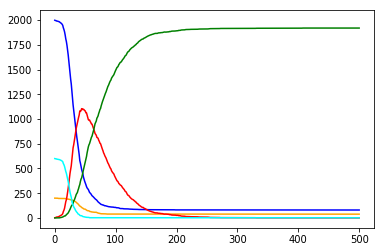

In [82]:
plt.plot( np.linspace(0,it,it), nH, color = 'blue')
plt.plot( np.linspace(0,it,it), nE, color = 'orange')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nR, color = 'green')
plt.plot( np.linspace(0,it,it), nC, color = 'cyan')

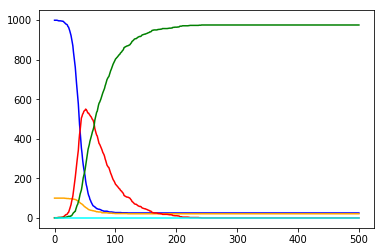

In [62]:
plt.plot( np.linspace(0,it,it), nH, color = 'blue')
plt.plot( np.linspace(0,it,it), nE, color = 'orange')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nR, color = 'green')
plt.plot( np.linspace(0,it,it), nC, color = 'cyan')

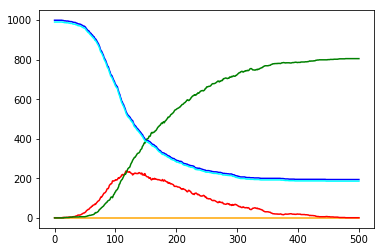

In [70]:
plt.plot( np.linspace(0,it,it), nH, color = 'blue')
plt.plot( np.linspace(0,it,it), nE, color = 'orange')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nR, color = 'green')
plt.plot( np.linspace(0,it,it), nC, color = 'cyan')

In [54]:
nH+nZ+nR+ nHR

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 10

In [48]:
print('Porcentaje de no egoistas muertos')
#print((nH[0] - nE[0] - (nH[-1] - nE[-1]))/(nH[0] - nE[0]))
print((N-1 - frac*N - (nH[-1] - nE[-1]))/(N-1 -frac*N))

Porcentaje de no egoistas muertos


NameError: name 'frac' is not defined

In [7]:
print('Porcentaje de egoistas muertos')
print(((N*frac) - nE[-1])/(N*frac))

Porcentaje de egoistas muertos
0.17066666666666666


In [8]:
N = 5000
kav = 10
p = kav/(N-1)
it = 500

net = nx.fast_gnp_random_graph(N, p, directed = False) 
adj = nx.adjacency_matrix(net) # adj is a Sparse Matrix of CSR (compressed sparse row) format. 
                               # this means that row slicing is fast

beta = 0.03 # infection probability in a zombie-human encounter
alpha = 0.03 # removal probability
sigma = 0.95 #probabilidad de cortar enlace de los egoistas
frac = 0.3
delta = 0.002 #muerte humanos

nH, nZ, nR, nE = selfish_delta(N, adj, alpha, beta, delta, sigma, frac, it)

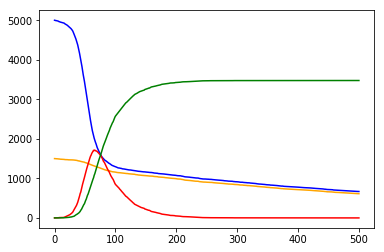

In [9]:
plt.plot( np.linspace(0,it,it), nH, color = 'blue')
plt.plot( np.linspace(0,it,it), nE, color = 'orange')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nR, color = 'green')

# ESTADÍSTICAS

In [ ]:
N = 2500
kav = 10
p = kav/(N-1)


## VICTOR: DESCOMENTA LA SIGUIENTE LÍNEA
#sigma_list = np.linspace(0.1,0.5,5)
## ANTONIO: DESCOMENTA LA SIGUIENTE LÍNEA
#sigma_list = np.linspace(0.6,0.9,4)

rep = 30
it = 300

beta = 0.03 
alpha = 0.03 
frac = 0.35

nHav = np.zeros(np.size(sigma_list))
nZav = np.zeros(np.size(sigma_list))
nRav = np.zeros(np.size(sigma_list))
nCav = np.zeros(np.size(sigma_list))

for j in range(0,np.size(sigma_list)):
    
    nHfinal = np.zeros(rep)
    nZfinal = np.zeros(rep)
    nRfinal = np.zeros(rep)
    nCfinal = np.zeros(rep)
    
    sigma = sigma_list[j]
    for i in range(0, rep):
        net = nx.fast_gnp_random_graph(N, p, directed = False) 
        adj = nx.adjacency_matrix(net)  
        nH, nZ, nR, nC = selfish(N, adj, alpha, beta, sigma, frac, it)
        nHfinal[i] = nH[-1]
        nZfinal[i] = nZ[-1]
        nRfinal[i] = nR[-1]
        nCfinal[i] = nC[-1]
    
    nHav[j] = np.average(nHfinal)
    nZav[j] = np.average(nZfinal)
    nRav[j] = np.average(nRfinal)
    nCav[j] = np.average(nCfinal)
